# p-value tests on H1C IDR3

Nick Kern
<br>
June 2022

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
import glob
import hera_cal as hc
import hera_pspec as hp
from pyuvdata import UVBeam, UVData, UVCal, UVFlag, utils as uvutils
import pyuvdata
from scipy import stats, signal, interpolate
from memory_profiler import memory_usage
import copy
import matplotlib.gridspec as gridspec
import pandas

/lustre/aoc/projects/hera/nkern/anaconda3/envs/py38/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/lustre/aoc/projects/hera/nkern/anaconda3/envs/py38/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/lustre/aoc/projects/hera/nkern/anaconda3/envs/py38/lib/python3.8/site-packages/hera_sim/__init__.py:23: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interf

In [2]:
# add utils.py helper IO and plotting functions to path
import sys
import imp
sys.path.insert(1, "../../")
import utils
imp.reload(utils);

# load the uvpspec objects and plot

In [3]:
band1_dfs = sorted(glob.glob('results_files/Pofk*Band_1*'))
band2_dfs = sorted(glob.glob('results_files/Pofk*Band_2*'))

In [4]:
band1_uvps, band2_uvps = [], []
fields = ['A', 'B', 'C', 'D', 'E']
for b1_df, b2_df in zip(band1_dfs, band2_dfs):
    uvp = hp.UVPSpec()
    uvp.read_hdf5(b1_df)
    band1_uvps.append(uvp)
    uvp = hp.UVPSpec()
    uvp.read_hdf5(b2_df)
    band2_uvps.append(uvp)

In [5]:
all_uvps = [band1_uvps, band2_uvps]

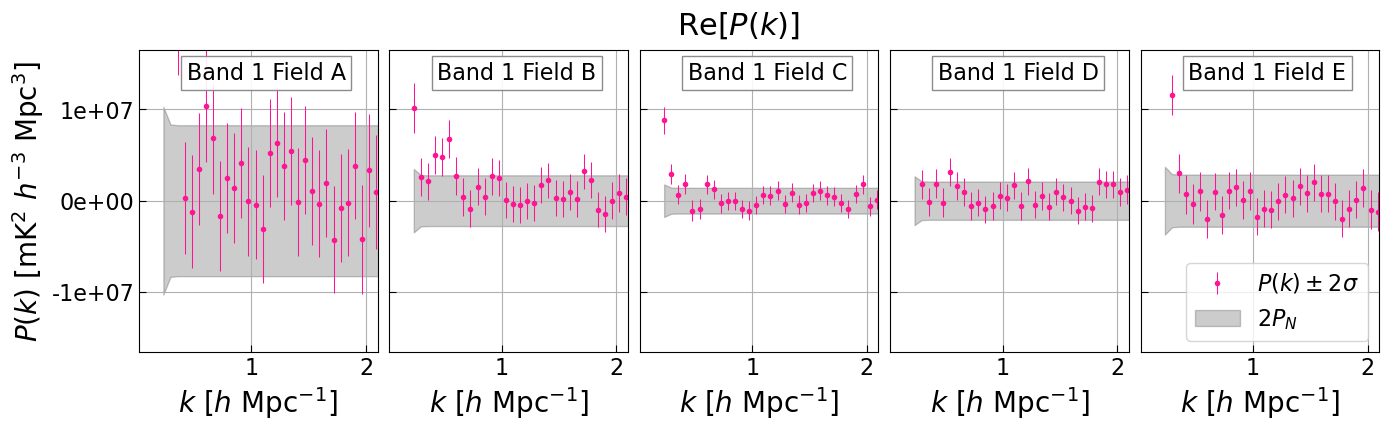

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4), dpi=100)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set params
xlim = .02, 2.1

redact = False

for i in range(5):
    # get data
    ax = axes[i]
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
    u = band1_uvps[i]
    kp = u.get_kparas(0)
    ks = slice(np.argmin(np.abs(kp - 0.23)), None, 1)
    
    renorm = 1

    y = np.real(u.data_array[0].squeeze().copy()[ks]) * renorm
    yerr = np.sqrt(np.diagonal(u.cov_array_real[0].squeeze()))[ks] * renorm
    pn = u.stats_array['P_N'][0].real.squeeze()[ks] * renorm
    k = kp[ks]
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))

    # plot data
    p1 = ax.errorbar(k, y, marker='o', ms=3, ls='',
                     yerr=yerr * 2, c='deeppink', lw=.75)
    shaded = ax.fill_between(k, -2*pn, 2*pn, color='k', alpha=0.2, zorder=0)

    # handle subplot
    ax.tick_params(labelsize=16, direction='in', size=5)
    ax.tick_params(direction='in', size=3, which='minor')
    ax.grid()
    ax.set_xlim(xlim)
    if i == 0:
        ylim = -np.nanmedian(pn)*4, np.nanmedian(pn)*4
    ax.set_ylim(ylim)
    ax.text(0.2, 0.9, "Band {} Field {}".format(1, fields[i]), fontsize=16,
            transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
    ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=20)
    if i == 0:
        ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=20)
    else:
        ax.set_yticklabels([])
    if i == 4:
        ax.legend([p1, shaded], [r'$P(k)\pm2\sigma$', r'$2P_N$'], fontsize=16, loc='lower right')
        
fig.suptitle(r"Re$[P(k)]$", fontsize=22)

if redact:
    fig.axes[0].set_yticklabels(['', 'here', 'to see', 'nothing'], rotation=45)
    fig.axes[0].set_ylabel(r'$P(k)$', fontsize=20)

figname = "plots/sph_pk_band1_real_w_errors.png"
if redact:
    figname = figname.replace("errors", "errors_redacted")

#fig.savefig(figname, dpi=150, bbox_inches='tight')

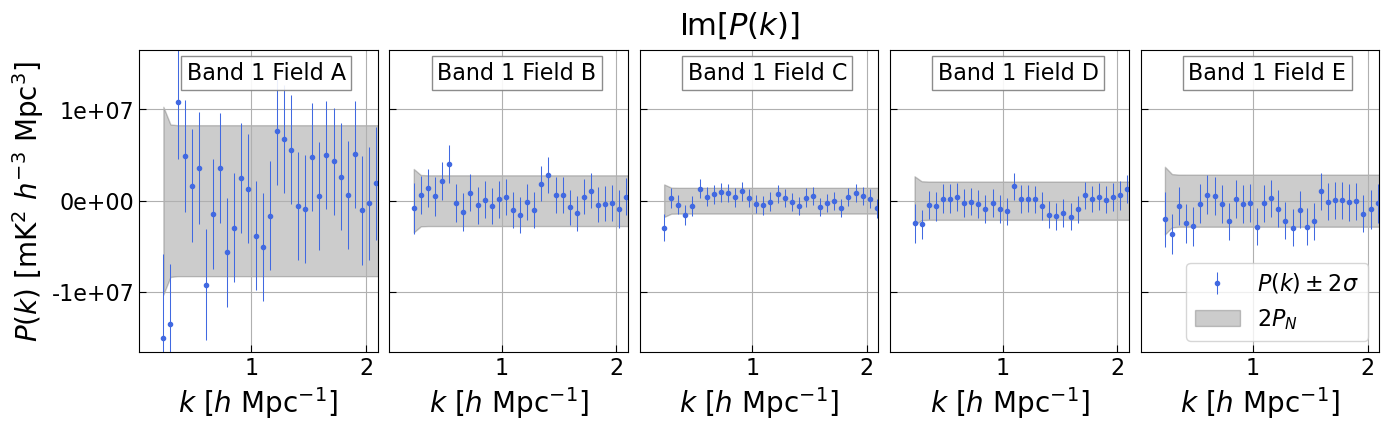

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4), dpi=100)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set params
xlim = .02, 2.1

redact = False

for i in range(5):
    # get data
    ax = axes[i]
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
    u = band1_uvps[i]
    kp = u.get_kparas(0)
    ks = slice(np.argmin(np.abs(kp - 0.22)), None, 1)
    
    renorm = 1

    y = np.imag(u.data_array[0].squeeze().copy()[ks]) * renorm
    yerr = np.sqrt(np.diagonal(u.cov_array_real[0].squeeze()))[ks] * renorm
    pn = u.stats_array['P_N'][0].real.squeeze()[ks] * renorm
    k = kp[ks]
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))

    # plot data
    p1 = ax.errorbar(k, y, marker='o', ms=3, ls='',
                     yerr=yerr * 2, c='royalblue', lw=.75)
    shaded = ax.fill_between(k, -2*pn, 2*pn, color='k', alpha=0.2, zorder=0)

    # handle subplot
    ax.tick_params(labelsize=16, direction='in', size=5)
    ax.tick_params(direction='in', size=3, which='minor')
    ax.grid()
    ax.set_xlim(xlim)
    if i == 0:
        ylim = -np.nanmedian(pn)*4, np.nanmedian(pn)*4
    ax.set_ylim(ylim)
    ax.text(0.2, 0.9, "Band {} Field {}".format(1, fields[i]), fontsize=16,
            transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
    ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=20)
    if i == 0:
        ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=20)
    else:
        ax.set_yticklabels([])
    if i == 4:
        ax.legend([p1, shaded], [r'$P(k)\pm2\sigma$', r'$2P_N$'], fontsize=16, loc='lower right')
        
fig.suptitle(r"Im$[P(k)]$", fontsize=22)

if redact:
    fig.axes[0].set_yticklabels(['', 'here', 'to see', 'nothing'], rotation=45)
    fig.axes[0].set_ylabel(r'$P(k)$', fontsize=20)

figname = "plots/sph_pk_band1_imag_w_errors.png"
if redact:
    figname = figname.replace("errors", "errors_redacted")

#fig.savefig(figname, dpi=150, bbox_inches='tight')

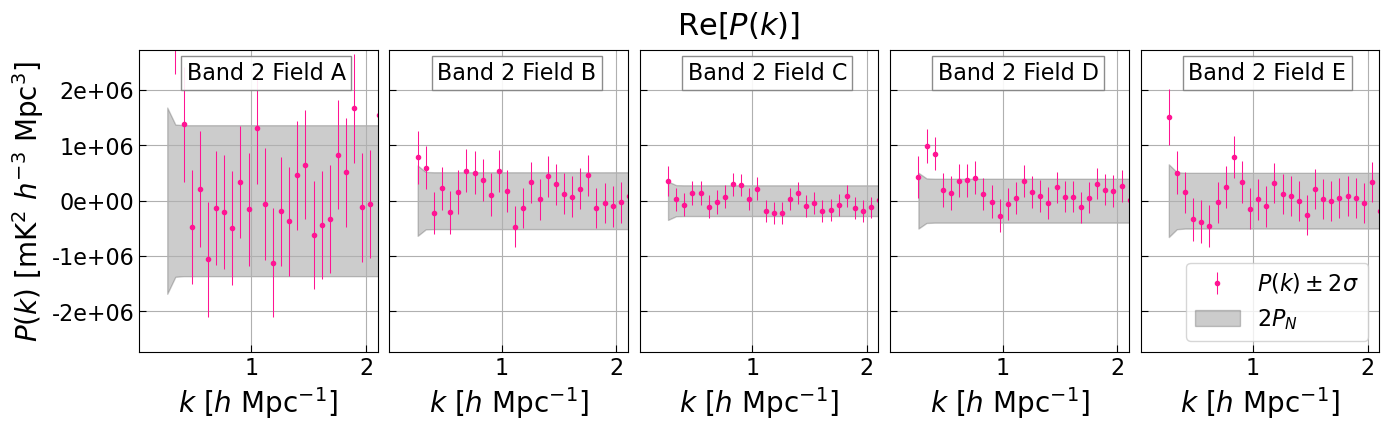

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4), dpi=100)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set params
xlim = .02, 2.1

redact = False

for i in range(5):
    # get data
    ax = axes[i]
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
    u = band2_uvps[i]
    kp = u.get_kparas(0)
    ks = slice(np.argmin(np.abs(kp - 0.26)), None, 1)
    
    renorm = 1

    y = np.real(u.data_array[0].squeeze().copy()[ks]) * renorm
    yerr = np.sqrt(np.diagonal(u.cov_array_real[0].squeeze()))[ks] * renorm
    pn = u.stats_array['P_N'][0].real.squeeze()[ks] * renorm
    k = kp[ks]
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))

    # plot data
    p1 = ax.errorbar(k, y, marker='o', ms=3, ls='',
                     yerr=yerr * 2, c='deeppink', lw=.75)
    shaded = ax.fill_between(k, -2*pn, 2*pn, color='k', alpha=0.2, zorder=0)

    # handle subplot
    ax.tick_params(labelsize=16, direction='in', size=5)
    ax.tick_params(direction='in', size=3, which='minor')
    ax.grid()
    ax.set_xlim(xlim)
    if i == 0:
        ylim = -np.nanmedian(pn)*4, np.nanmedian(pn)*4
    ax.set_ylim(ylim)
    ax.text(0.2, 0.9, "Band {} Field {}".format(2, fields[i]), fontsize=16,
            transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
    ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=20)
    if i == 0:
        ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=20)
    else:
        ax.set_yticklabels([])
    if i == 4:
        ax.legend([p1, shaded], [r'$P(k)\pm2\sigma$', r'$2P_N$'], fontsize=16, loc='lower right')
        
fig.suptitle(r"Re$[P(k)]$", fontsize=22)

if redact:
    fig.axes[0].set_yticklabels(['', 'here', 'to see', 'nothing'], rotation=45)
    fig.axes[0].set_ylabel(r'$P(k)$', fontsize=20)

figname = "plots/sph_pk_band2_real_w_errors.png"
if redact:
    figname = figname.replace("errors", "errors_redacted")

#fig.savefig(figname, dpi=150, bbox_inches='tight')

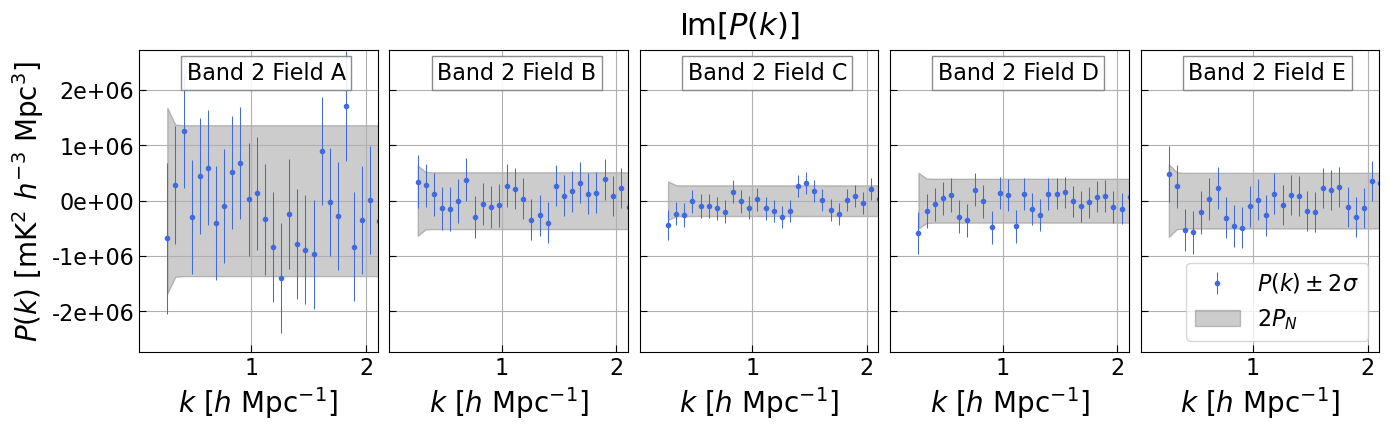

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4), dpi=100)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set params
xlim = .02, 2.1

redact = False

for i in range(5):
    # get data
    ax = axes[i]
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
    u = band2_uvps[i]
    kp = u.get_kparas(0)
    ks = slice(np.argmin(np.abs(kp - 0.26)), None, 1)
    
    renorm = 1#2*np.pi**2 / kp[ks]**3

    y = np.imag(u.data_array[0].squeeze().copy()[ks]) * renorm
    yerr = np.sqrt(np.diagonal(u.cov_array_real[0].squeeze()))[ks] * renorm
    pn = u.stats_array['P_N'][0].real.squeeze()[ks] * renorm
    k = kp[ks]
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))

    # plot data
    p1 = ax.errorbar(k, y, marker='o', ms=3, ls='',
                     yerr=yerr * 2, c='royalblue', lw=.75)
    shaded = ax.fill_between(k, -2*pn, 2*pn, color='k', alpha=0.2, zorder=0)

    # handle subplot
    ax.tick_params(labelsize=16, direction='in', size=5)
    ax.tick_params(direction='in', size=3, which='minor')
    ax.grid()
    ax.set_xlim(xlim)
    if i == 0:
        ylim = -np.nanmedian(pn)*4, np.nanmedian(pn)*4
    ax.set_ylim(ylim)
    ax.text(0.2, 0.9, "Band {} Field {}".format(2, fields[i]), fontsize=16,
            transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
    ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=20)
    if i == 0:
        ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=20)
    else:
        ax.set_yticklabels([])
    if i == 4:
        ax.legend([p1, shaded], [r'$P(k)\pm2\sigma$', r'$2P_N$'], fontsize=16, loc='lower right')
        
fig.suptitle(r"Im$[P(k)]$", fontsize=22)

if redact:
    fig.axes[0].set_yticklabels(['', 'here', 'to see', 'nothing'], rotation=45)
    fig.axes[0].set_ylabel(r'$P(k)$', fontsize=20)

figname = "plots/sph_pk_band2_imag_w_errors.png"
if redact:
    figname = figname.replace("errors", "errors_redacted")

#fig.savefig(figname, dpi=150, bbox_inches='tight')

# run p-value monte carlo tests

In [81]:
# likelihood tests: Monte Carlo chisq for each covariance, with different k cuts
N = 300000
n_x2 = {}
pvals_real,  pvals_imag, pvals_min = {}, {}, {}
k_cuts = [0.23, 0.5, 1.0]
for k, kc in enumerate(k_cuts):
    n_x2[k] = {}
    pvals_real[k], pvals_imag[k] = [], []
    for i in range(2):
        print("working on band {}".format(i+1))
        n_x2[k][i] = {}
        uvps = all_uvps[i]
        kp = uvps[0].get_kparas(0)
        ks = slice(np.argmax(kp > kc), None)
        pv_real, pv_imag = [], []
        for j in range(5):
            uvp = all_uvps[i][j]
            # get P_SN covariance
            cov_SN = uvp.cov_array_real[0].squeeze()[ks, ks]
            # normalize, and re-scale by P_N
            s = np.diag(1/np.sqrt(cov_SN.diagonal()))
            cov_N = s @ cov_SN @ s
            s = np.diag(uvp.stats_array['P_N'][0].squeeze()[ks].real)
            cov_N = s @ cov_N @ s
            n_x2[k][i][j] = utils.monte_carlo_chisq(cov_N, len(cov_N), N=N)
            patches = np.histogram(n_x2[k][i][j], bins=100)
            y = uvp.data_array[0].squeeze()[ks]
            pval_real = utils.p_value(y.real, cov_N, n_x2=n_x2[k][i][j])[1]
            pval_imag = utils.p_value(y.imag, cov_N, n_x2=n_x2[k][i][j])[1]
            # compute minimum p-value testable by N sims
            y, x = np.histogram(n_x2[k][i][j], bins=200)
            y = np.concatenate([[0], y])
            index = np.argmax((x > x.mean()) & (np.abs(y - 20) < 5))
            exceed = n_x2[k][i][j] > x[index]
            pval_min = sum(exceed) / exceed.size
            if pval_real < pval_min:
                pval_real = "< {:.3f}".format(pval_min)
            else:
                pval_real = "{:.3f}".format(pval_real)
            if pval_imag < pval_min:
                pval_imag = "< {:.3f}".format(pval_min)
            else:
                pval_imag = "{:.3f}".format(pval_imag)
            pv_real.append(pval_real)
            pv_imag.append(pval_imag)
        pvals_real[k].append(pv_real)
        pvals_imag[k].append(pv_imag)

working on band 1
working on band 2
working on band 1
working on band 2
working on band 1
working on band 2


In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cov_N)
plt.colorbar()
plt.title("k-k index thermal noise covariance")

In [82]:
data = {r'Re[P(k)] Band 1': ['Field A', 'Field B', 'Field C', 'Field D', 'Field E'],
        r'p-value for k >= 0.23': pvals_real[0][0],
        r'p-value for k >= 0.5': pvals_real[1][0],
        r'p-value for k >= 1.0': pvals_real[2][0]}
df = pandas.DataFrame(data)
gmap = np.array([[0.0 if '<' in p else float(p) for p in pvals[0]] for pvals in pvals_real.values()]).T
df.style.background_gradient(axis=None, cmap='RdPu_r', gmap=gmap, subset=list(data.keys())[1:],
                             low=0.09, vmin=0, vmax=0.05)

,Re[P(k)] Band 1,p-value for k >= 0.23,p-value for k >= 0.5,p-value for k >= 1.0
0,Field A,< 0.001,0.379,0.464
1,Field B,< 0.001,0.015,0.729
2,Field C,< 0.001,0.016,0.050
3,Field D,< 0.001,0.015,0.024
4,Field E,< 0.001,0.744,0.939


In [83]:
data = {r'Im[P(k)] Band 1': ['Field A', 'Field B', 'Field C', 'Field D', 'Field E'],
        r'p-value for k >= 0.23': pvals_imag[0][0],
        r'p-value for k >= 0.5': pvals_imag[1][0],
        r'p-value for k >= 1.0': pvals_imag[2][0]}
df = pandas.DataFrame(data)
gmap = np.array([[0.0 if '<' in p else float(p) for p in pvals[0]] for pvals in pvals_imag.values()]).T
df.style.background_gradient(axis=None, cmap='RdPu_r', gmap=gmap, subset=list(data.keys())[1:],
                             low=0.09, vmin=0, vmax=0.05)

,Im[P(k)] Band 1,p-value for k >= 0.23,p-value for k >= 0.5,p-value for k >= 1.0
0,Field A,< 0.001,0.053,0.090
1,Field B,0.773,0.632,0.843
2,Field C,0.182,0.790,0.859
3,Field D,0.810,0.925,0.686
4,Field E,0.345,0.685,0.507


In [84]:
data = {r'Re[P(k)] Band 2': ['Field A', 'Field B', 'Field C', 'Field D', 'Field E'],
        r'p-value for k >= 0.23': pvals_real[0][1],
        r'p-value for k >= 0.5': pvals_real[1][1],
        r'p-value for k >= 1.0': pvals_real[2][1]}
df = pandas.DataFrame(data)
gmap = np.array([[0.0 if '<' in p else float(p) for p in pvals[1]] for pvals in pvals_real.values()]).T
df.style.background_gradient(axis=None, cmap='RdPu_r', gmap=gmap, subset=list(data.keys())[1:],
                             low=0.09, vmin=0, vmax=0.05)

,Re[P(k)] Band 2,p-value for k >= 0.23,p-value for k >= 0.5,p-value for k >= 1.0
0,Field A,< 0.001,0.181,0.123
1,Field B,0.077,0.385,0.652
2,Field C,0.198,0.215,0.315
3,Field D,0.008,0.767,0.937
4,Field E,0.006,0.275,0.723


In [85]:
data = {r'Im[P(k)] Band 2': ['Field A', 'Field B', 'Field C', 'Field D', 'Field E'],
        r'p-value for k >= 0.23': pvals_imag[0][1],
        r'p-value for k >= 0.5': pvals_imag[1][1],
        r'p-value for k >= 1.0': pvals_imag[2][1]}
df = pandas.DataFrame(data)
gmap = np.array([[0.0 if '<' in p else float(p) for p in pvals[1]] for pvals in pvals_imag.values()]).T
df.style.background_gradient(axis=None, cmap='RdPu_r', gmap=gmap, subset=list(data.keys())[1:],
                             low=0.09, vmin=0, vmax=0.05)

,Im[P(k)] Band 2,p-value for k >= 0.23,p-value for k >= 0.5,p-value for k >= 1.0
0,Field A,0.263,0.318,0.143
1,Field B,0.498,0.398,0.354
2,Field C,0.041,0.121,0.095
3,Field D,0.100,0.115,0.366
4,Field E,0.384,0.716,0.819
